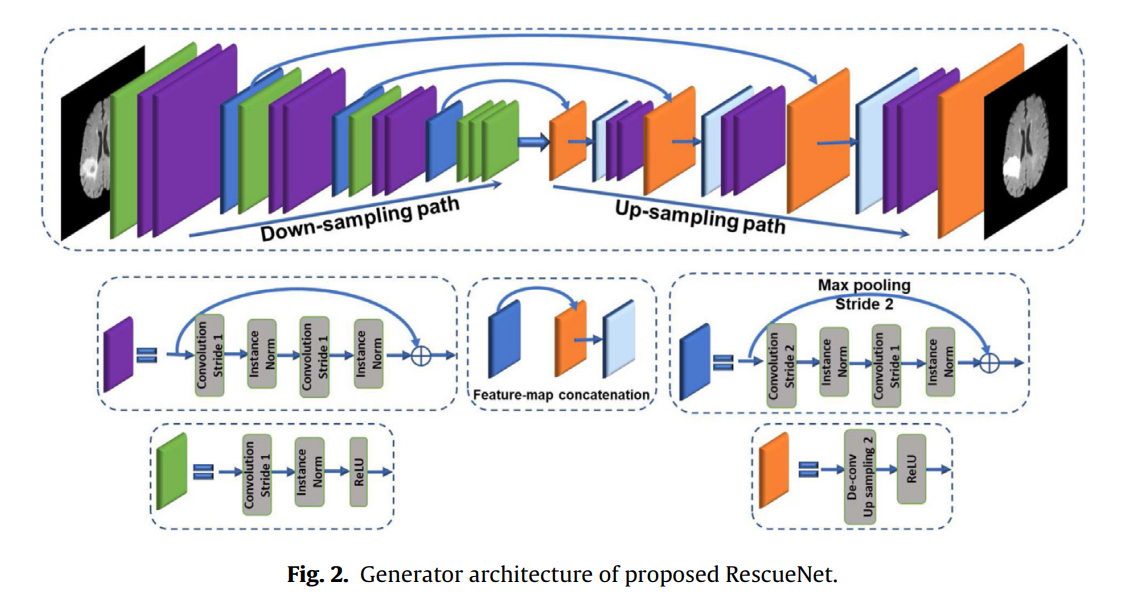

In [1]:
from keras.models import Model
from keras.layers import Add, ReLU, Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want

def green_block(num_filter, in_layer):
    x = Conv3D(num_filter, (3, 3, 3),kernel_initializer=kernel_initializer, padding='same')(in_layer)
    x = BatchNormalization(axis = -1)(x)
    x = ReLU()(x)
    return x

2022-10-30 11:37:43.715848: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def violet_block(num_filter, in_layer):
    x = Conv3D(num_filter, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(in_layer)
    x = BatchNormalization(axis = -1)(x)
    x = ReLU()(x)
    x = Conv3D(num_filter, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(x)
    x = BatchNormalization(axis = -1)(x)
    x = Add()([x, in_layer])
    x = ReLU()(x)
    
    return x    

In [3]:
def blue_block(num_filter, in_layer):
    m = MaxPooling3D((2, 2, 2))(in_layer)
    m = ReLU()(m)
    x = Conv3D(num_filter, (3, 3, 3), strides=(2, 2, 2), kernel_initializer=kernel_initializer, padding='same')(in_layer)
    x = BatchNormalization(axis = -1)(x)
    x = ReLU()(x)
    x = Conv3D(num_filter, (3, 3, 3), strides=(1, 1, 1),kernel_initializer=kernel_initializer, padding='same')(x)
    x = BatchNormalization(axis = -1)(x)
    x = Add()([x, m])
    x = ReLU()(x)
    return x

In [4]:
def orange_block(num_filter, in_layer, stride=1):
    if stride==1:
        x = Conv3DTranspose(num_filter, (2, 2, 2), strides=(1, 1, 1), padding='same')(in_layer)
        x= ReLU()(x)
    if stride==2:
        x = Conv3DTranspose(num_filter, (2, 2, 2), strides=(2, 2, 2), padding='same')(in_layer)
        x= ReLU()(x)
    return x

In [5]:
def Rescue_Net(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    #Build the model
    num_filter = 32
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    
    c1 = green_block(num_filter, s)
    c1 = violet_block(num_filter, c1)
    c1 = violet_block(num_filter, c1)
    c1 = blue_block(num_filter, c1)
    
    c2 = green_block(2*num_filter, c1)
    c2 = violet_block(2*num_filter, c2)
    c2 = violet_block(2*num_filter, c2)
    c2 = blue_block(2*num_filter, c2)
    
    c3 = green_block(4*num_filter, c2)
    c3 = violet_block(4*num_filter, c3)
    c3 = violet_block(4*num_filter, c3)
    c3 = blue_block(4*num_filter, c3)
    
    c4 = green_block(4*num_filter, c3)
    c5 = green_block(4*num_filter, c4)
    c6 = green_block(8*num_filter, c5)
    
    d4 = orange_block(4*num_filter, c6, stride=1)
    c7 = concatenate([c3, d4])
    c7 = violet_block(8*num_filter, c7)
    c7 = violet_block(8*num_filter, c7)
    
    d3 = orange_block(2*num_filter, c7, stride=2)
    c8 = concatenate([c2, d3])
    c8 = violet_block(4*num_filter, c8)
    c8 = violet_block(4*num_filter, c8)
    
    d2 = orange_block(num_filter, c8, stride=2)
    c9 = concatenate([c1, d2])
    c9 = violet_block(2*num_filter, c9)
    c9 = violet_block(2*num_filter, c9)
    
    d1 = orange_block(num_filter, c9, stride=2)
    outputs = Conv3DTranspose(num_classes, (2, 2, 2), strides=(1, 1, 1),activation='sigmoid', padding='same')(d1)
#     outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    
    return model
 
#Test if everything is working ok. 
model = Rescue_Net(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=4, 
                          num_classes=1)

model.summary()
print(model.input_shape)
print(model.output_shape)

2022-10-30 11:37:45.129730: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-30 11:37:45.129824: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mig): /proc/driver/nvidia/version does not exist
2022-10-30 11:37:45.130960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 4)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  3488        ['input_1[0][0]']                
                                8, 32)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  128        ['conv3d[0][0]']                 
 alization)                     8, 32)                                                        

                                                                                                  
 conv3d_7 (Conv3D)              (None, 64, 64, 64,   55360       ['re_lu_7[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 64,   256        ['conv3d_7[0][0]']               
 rmalization)                   64)                                                               
                                                                                                  
 re_lu_8 (ReLU)                 (None, 64, 64, 64,   0           ['batch_normalization_7[0][0]']  
                                64)                                                               
                                                                                                  
 conv3d_8 

 ormalization)                  128)                                                              
                                                                                                  
 re_lu_16 (ReLU)                (None, 32, 32, 32,   0           ['batch_normalization_14[0][0]'] 
                                128)                                                              
                                                                                                  
 conv3d_15 (Conv3D)             (None, 32, 32, 32,   442496      ['re_lu_16[0][0]']               
                                128)                                                              
                                                                                                  
 batch_normalization_15 (BatchN  (None, 32, 32, 32,   512        ['conv3d_15[0][0]']              
 ormalization)                  128)                                                              
          

 conv3d_22 (Conv3D)             (None, 16, 16, 16,   442496      ['re_lu_24[0][0]']               
                                128)                                                              
                                                                                                  
 batch_normalization_22 (BatchN  (None, 16, 16, 16,   512        ['conv3d_22[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 re_lu_25 (ReLU)                (None, 16, 16, 16,   0           ['batch_normalization_22[0][0]'] 
                                128)                                                              
                                                                                                  
 conv3d_23 (Conv3D)             (None, 16, 16, 16,   884992      ['re_lu_25[0][0]']               
          

                                                                                                  
 re_lu_33 (ReLU)                (None, 32, 32, 32,   0           ['batch_normalization_28[0][0]'] 
                                128)                                                              
                                                                                                  
 conv3d_29 (Conv3D)             (None, 32, 32, 32,   442496      ['re_lu_33[0][0]']               
                                128)                                                              
                                                                                                  
 batch_normalization_29 (BatchN  (None, 32, 32, 32,   512        ['conv3d_29[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 add_11 (A

                                64)                               're_lu_39[0][0]']               
                                                                                                  
 re_lu_41 (ReLU)                (None, 64, 64, 64,   0           ['add_14[0][0]']                 
                                64)                                                               
                                                                                                  
 conv3d_transpose_3 (Conv3DTran  (None, 128, 128, 12  16416      ['re_lu_41[0][0]']               
 spose)                         8, 32)                                                            
                                                                                                  
 re_lu_42 (ReLU)                (None, 128, 128, 12  0           ['conv3d_transpose_3[0][0]']     
                                8, 32)                                                            
          